# thal2 2:3 Bifurcation Diagrams

# Inits

In [1]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
# import nmCoupling_old as nm
import response as rp

import thal2 as t2

from lib.util import (get_phase, freq_est, get_tongue_1d, pl_exist_1d,
get_period, bif1d, follow_phase_diffs, phase_lock_r3d, follow_locking_3d)

from lib.rhs import _redu_c,_full
from lib.rhs import _redu_3dc_thal as _redu_3dc

from lib.plot_util import (add_diagram_1d_scatter, draw_full_solutions, 
quick_plot_combined, quick_plot_r)

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sym

from scipy.optimize import root,bisect
from copy import deepcopy
import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

nmc = nm.nmCoupling
rsp = rp.Response

## Dicts

In [2]:
kw_sim = {'rtol':1e-7,'atol':1e-7,'method':'LSODA'}

In [3]:
pd1 = {'gL':0.05,'gna':3,'gk':5,
       'gt':5,'eL':-70,'ena':50,
       'ek':-90,'et':0,'esyn':-1,
       'c':1,'alpha':3,'beta':2,
       'sigmat':0.8,'vt':-20,
       'ib':3.5,'del':0,'om':1,'om_fix':1}

In [4]:
# default period must be 2*np.pi
kws1 = {'var_names':['v','h','r','w'],
        'pardict':pd1,
        'rhs':t2.rhs,
        'coupling':t2.coupling,
        'init':np.array([-.64,0.71,0.25,0,6]),
        'TN':20000,
        'trunc_order':3,
        'z_forward':False,
        'i_forward':[False,True,False,False,False,False],
        'i_bad_dx':[False,True,False,False,False,False],
        'max_iter':50,
        'rtol':1e-12,
        'atol':1e-12,
        'rel_tol':1e-9,
        'save_fig':False,
        'lc_prominence':.05,
        'factor':.5}

## Defs

In [5]:
kw_bif = {'method':'LSODA','dense_output':True,'rtol':1e-9,'atol':1e-9}

In [6]:
etup23 = (.001,.1,100)
eps_list23r = np.linspace(*etup23)

In [7]:
x_temp = np.linspace(-np.pi,3*np.pi,500)

## Initialize Response Functions

In [8]:
system1 = rsp(idx=0,model_name='thal0_35',**kws1)
system2 = rsp(idx=1,model_name='thal1_35',**kws1)

mkdir ./data/thal0_35/
* Loading LC data...
self.T 6.283185307179586 omfix 1.6947246128737048
* Loading monodromy...
* Floquet Exponent kappa =-0.03594482780785962
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...
mkdir ./data/thal1_35/
* Loading LC data...
self.T 6.283185307179586 omfix 1.6947246128737048
* Loading monodromy...
* Floquet Exponent kappa =-0.03594482780785962
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


In [9]:
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',2),'_m':('om1',3),
        'NH':1024,'save_fig':False}

# del=0.0

In [10]:
del23_p0 = 0
a23_p0 = nm.nmCoupling(**kw_nm, del1=del23_p0)

pfactor 20
* Loading p symbolic...
* Loading p symbolic...
* Loading H symbolic...
* Loading H symbolic...
* Loading H thal0_35, order=0...
* Loading H thal1_35, order=0...
* Loading H thal0_35, order=1...
* Loading H thal1_35, order=1...
* Loading H thal0_35, order=2...
* Loading H thal1_35, order=2...
* Loading H thal0_35, order=3...
* Loading H thal1_35, order=3...


## Get Branches Full

In [11]:
kw_p0 = {'a':a23_p0,'del1':del23_p0,'recompute':False,
         'bifdir':'bif1d_thal2/','_full_rhs':_full}

In [12]:
data_p0_list = []

In [13]:
in_dicts = [dict(init=0,eps_init=0.1,eps_final=0.007,deps=-.01),
            dict(init=0,eps_init=0.01,eps_final=0.0005,deps=-.001)]

In [14]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_p0)
    data_p0_list.append(dat)
fname = kw_p0['bifdir']+'hyper_thal2_23_p0.txt'

fname1 td_branch_init=0_nm=23_del=0_ei=0.1_ef=0.007_de=-0.01.txt
fname2 ts_branch_init=0_nm=23_del=0_ei=0.1_ef=0.007_de=-0.01.txt
fname1 td_branch_init=0_nm=23_del=0_ei=0.01_ef=0.0005_de=-0.001.txt
fname2 ts_branch_init=0_nm=23_del=0_ei=0.01_ef=0.0005_de=-0.001.txt


In [15]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [16]:
data_r3d_p0_list = []

In [17]:
# find init for this branch
_,init = phase_lock_r3d([1,0,0],a23_p0,.05,_redu_3dc)
print(init)

t_diff 3.78445037168994961, Y=[-15.06510555  -0.09776323  -0.17794343]                                              
[ 3.7845 -0.0978 -0.1779]


In [18]:
# branch 1
dat = follow_locking_3d(init,a23_p0,(.05,.11,.01),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0_list.append(dat)

In [19]:
# branch 1
dat = follow_locking_3d(init,a23_p0,(.05,.001,-.001),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0_list.append(dat)

## Plot

eps_min 0.008000000000000002


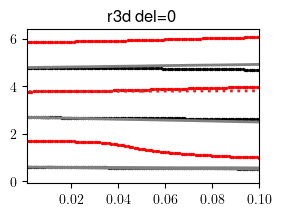

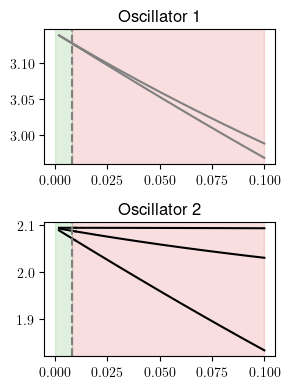

In [20]:
quick_plot_combined(a23_p0,
                    kw_f={'data_list':data_p0_list},
                    kw_r3d={'data_list':data_r3d_p0_list},
                    kw_r={'etup':etup23})

# del=0.001

In [21]:
del23_p001 = 0.001
a23_p001 = nm.nmCoupling(**kw_nm, del1=del23_p001)

pfactor 20
* Loading p symbolic...
* Loading p symbolic...
* Loading H symbolic...
* Loading H symbolic...
* Loading H thal0_35, order=0...
* Loading H thal1_35, order=0...
* Loading H thal0_35, order=1...
* Loading H thal1_35, order=1...
* Loading H thal0_35, order=2...
* Loading H thal1_35, order=2...
* Loading H thal0_35, order=3...
* Loading H thal1_35, order=3...


## Get Branches Full

In [22]:
kw_p001 = {'a':a23_p001,'del1':del23_p001,'recompute':False,
         'bifdir':'bif1d_thal2/','_full_rhs':_full}

In [23]:
data_p001_list = []

In [24]:
in_dicts = [dict(init=0,eps_init=0.1,eps_final=0.009,deps=-.01),
            dict(init=0,eps_init=0.01,eps_final=0.0005,deps=-.001)]

In [25]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_p001)
    data_p001_list.append(dat)
fname = kw_p001['bifdir']+'hyper_thal2_23_p001.txt'

fname1 td_branch_init=0_nm=23_del=0.001_ei=0.1_ef=0.009_de=-0.01.txt
fname2 ts_branch_init=0_nm=23_del=0.001_ei=0.1_ef=0.009_de=-0.01.txt
fname1 td_branch_init=0_nm=23_del=0.001_ei=0.01_ef=0.0005_de=-0.001.txt
fname2 ts_branch_init=0_nm=23_del=0.001_ei=0.01_ef=0.0005_de=-0.001.txt


In [26]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [27]:
data_r3d_p001_list = []

In [28]:
# find init for this branch mid
_,init = phase_lock_r3d([0,0,0],a23_p001,.05,_redu_3dc)
print(init)

t_diff 5.95724361680905-09, Y=[-0.32594169 -0.08448709 -0.15152501]                                              
[ 5.9572 -0.0845 -0.1515]


In [29]:
# branch 1
dat = follow_locking_3d(init,a23_p001,(.05,.11,.01),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p001_list.append(dat)

In [30]:
# branch 1
dat = follow_locking_3d(init,a23_p001,(.05,.001,-.002),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p001_list.append(dat)

## Plot

eps_min 0.008000000000000002


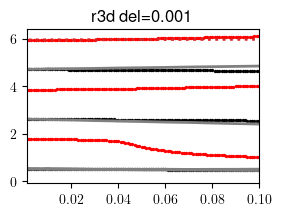

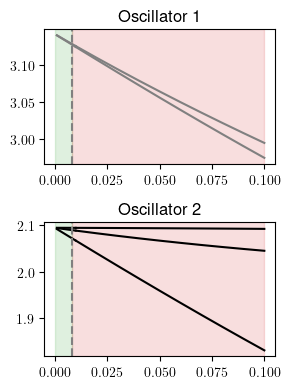

In [31]:
quick_plot_combined(a23_p001,
                    kw_f={'data_list':data_p001_list},
                    kw_r3d={'data_list':data_r3d_p001_list},
                    kw_r={'etup':etup23})

# del=0.003

In [86]:
del23_p003 = 0.003
a23_p003 = nm.nmCoupling(**kw_nm, del1=del23_p003)

pfactor 20
* Loading p symbolic...
* Loading p symbolic...
* Loading H symbolic...
* Loading H symbolic...
* Loading H thal0_35, order=0...
* Loading H thal1_35, order=0...
* Loading H thal0_35, order=1...
* Loading H thal1_35, order=1...
* Loading H thal0_35, order=2...
* Loading H thal1_35, order=2...
* Loading H thal0_35, order=3...
* Loading H thal1_35, order=3...


## Get Branches Full

In [92]:
kw_p003 = {'a':a23_p003,'del1':del23_p003,'recompute':False,
         'bifdir':'bif1d_thal2/','_full_rhs':_full}

In [93]:
data_p003_list = []

In [94]:
in_dicts = [dict(init=0,eps_init=0.1,eps_final=0.009, deps=-.01),
            dict(init=0,eps_init=0.01,eps_final=0.0005,deps=-.001)]

In [95]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_p003)
    data_p003_list.append(dat)
fname = kw_p003['bifdir']+'hyper_thal2_23_p003.txt'

fname1 td_branch_init=0_nm=23_del=0.003_ei=0.1_ef=0.009_de=-0.01.txt
fname2 ts_branch_init=0_nm=23_del=0.003_ei=0.1_ef=0.009_de=-0.01.txt
fname1 td_branch_init=0_nm=23_del=0.003_ei=0.01_ef=0.0005_de=-0.001.txt
fname2 ts_branch_init=0_nm=23_del=0.003_ei=0.01_ef=0.0005_de=-0.001.txt


In [96]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [38]:
data_r3d_p003_list = []

In [39]:
# find init for this branch mid
_,init = phase_lock_r3d([0,0,0],a23_p003,.05,_redu_3dc)
print(init)

t_diff 6.13073096718261109, Y=[-0.15245434 -0.05662589 -0.0886821 ]                                              
[ 6.1307 -0.0566 -0.0887]


In [40]:
# branch 1
dat = follow_locking_3d(init,a23_p003,(.05,.11,.01),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p003_list.append(dat)

In [41]:
# branch 1
dat = follow_locking_3d(init,a23_p003,(.05,.001,-.002),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p003_list.append(dat)

In [42]:
# find init for branch 2
_,init = phase_lock_r3d([2.5,0,0],a23_p003,.05,_redu_3dc)
print(init)

t_diff 2.43952338343508510, Y=[ 2.43952338 -0.05553699 -0.03192527]                                              
[ 2.4395 -0.0555 -0.0319]


In [43]:
# branch 2
dat = follow_locking_3d(init,a23_p003,(.05,.11,.01),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p003_list.append(dat)

In [44]:
# branch 2
dat = follow_locking_3d(init,a23_p003,(.05,.001,-.002),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p003_list.append(dat)

In [45]:
# find init for branch 3
_,init = phase_lock_r3d([5,0,0],a23_p003,.05,_redu_3dc)
print(init)

t_diff 4.53391848582837608, Y=[ 4.53391849 -0.05553699 -0.03192527]                                              
[ 4.5339 -0.0555 -0.0319]


In [46]:
# branch 3
dat = follow_locking_3d(init,a23_p003,(.05,.11,.01),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p003_list.append(dat)

In [47]:
# branch 3
dat = follow_locking_3d(init,a23_p003,(.05,.001,-.002),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p003_list.append(dat)

## Plot

eps_min 0.008000000000000002


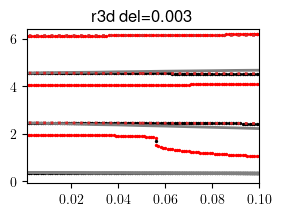

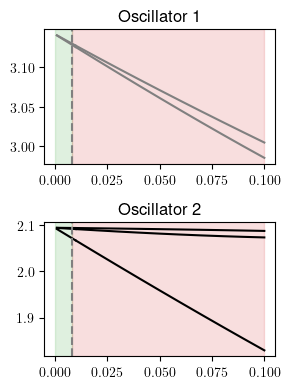

In [48]:
quick_plot_combined(a23_p003,
                    kw_f={'data_list':data_p003_list},
                    kw_r3d={'data_list':data_r3d_p003_list},
                    kw_r={'etup':etup23})

# del=0.004

In [49]:
del23_p004 = 0.004
a23_p004 = nm.nmCoupling(**kw_nm, del1=del23_p004)

pfactor 20
* Loading p symbolic...
* Loading p symbolic...
* Loading H symbolic...
* Loading H symbolic...
* Loading H thal0_35, order=0...
* Loading H thal1_35, order=0...
* Loading H thal0_35, order=1...
* Loading H thal1_35, order=1...
* Loading H thal0_35, order=2...
* Loading H thal1_35, order=2...
* Loading H thal0_35, order=3...
* Loading H thal1_35, order=3...


## Get Branches Full

In [50]:
kw_p004 = {'a':a23_p004,'del1':del23_p004,'recompute':False,
         'bifdir':'bif1d_thal2/','_full_rhs':_full}

In [51]:
data_p004_list = []

In [52]:
in_dicts = [dict(init=0,eps_init=0.05,eps_final=0.071,deps=.01),
            dict(init=0,eps_init=0.05,eps_final=0.0005,deps=-.002)]

In [53]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_p004)
    data_p004_list.append(dat)
fname = kw_p004['bifdir']+'hyper_thal2_23_p004.txt'

fname1 td_branch_init=0_nm=23_del=0.004_ei=0.05_ef=0.071_de=0.01.txt
fname2 ts_branch_init=0_nm=23_del=0.004_ei=0.05_ef=0.071_de=0.01.txt
fname1 td_branch_init=0_nm=23_del=0.004_ei=0.05_ef=0.0005_de=-0.002.txt
fname2 ts_branch_init=0_nm=23_del=0.004_ei=0.05_ef=0.0005_de=-0.002.txt


In [54]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [55]:
data_r3d_p004_list = []

In [56]:
# find init for this branch mid
_,init = phase_lock_r3d([5,0,0],a23_p004,.05,_redu_3dc)
print(init)

t_diff 4.17588906053783308, Y=[ 4.17588906 -0.03981976 -0.05427165]                                              
[ 4.1759 -0.0398 -0.0543]


In [57]:
# branch 1
dat = follow_locking_3d(init,a23_p004,(.05,.11,.01),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p004_list.append(dat)

In [58]:
# branch 1
dat = follow_locking_3d(init,a23_p004,(.05,.001,-.002),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p004_list.append(dat)

In [59]:
# find init for branch 2
_,init = phase_lock_r3d([2.5,0,0],a23_p004,.05,_redu_3dc)
print(init)

t_diff 2.32584623698593748, Y=[ 2.32584624 -0.03813004 -0.0321973 ]                                              
[ 2.3258 -0.0381 -0.0322]


In [60]:
# branch 2
dat = follow_locking_3d(init,a23_p004,(.05,.11,.01),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p004_list.append(dat)

In [61]:
# branch 2
dat = follow_locking_3d(init,a23_p004,(.05,.001,-.002),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p004_list.append(dat)

In [62]:
# find init for branch 3
_,init = phase_lock_r3d([.5,0,0],a23_p004,.05,_redu_3dc)
print(init)

t_diff 0.23145113459246333, Y=[ 0.23145113 -0.03813004 -0.0321973 ]                                              
[ 0.2315 -0.0381 -0.0322]


In [63]:
# branch 3
dat = follow_locking_3d(init,a23_p004,(.05,.11,.01),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p004_list.append(dat)

In [64]:
# branch 3
dat = follow_locking_3d(init,a23_p004,(.05,.001,-.002),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p004_list.append(dat)

## Plot

eps_min 0.007999999999999965


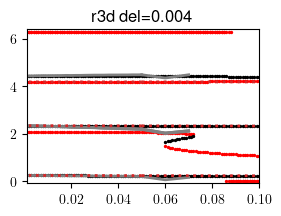

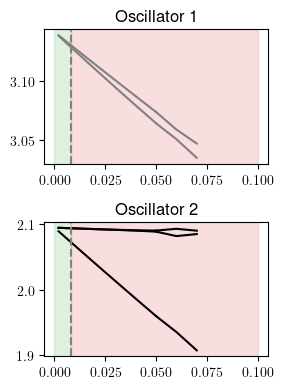

In [65]:
quick_plot_combined(a23_p004,
                    kw_f={'data_list':data_p004_list},
                    kw_r3d={'data_list':data_r3d_p004_list},
                    kw_r={'etup':etup23})

## Sims

In [66]:
eps23_p004 = 0.05
th_init23_p004 = 3

In [67]:
dt = .01;T_p004=2000
t23_p004 = np.arange(0,T_p004,dt)
args23_p004 = {'args':(a23_p004,eps23_p004,del23_p004),
               't_eval':t23_p004,**kw_sim}

In [68]:
y0a = a23_p004.system1.lc['dat'][int((th_init23_p004/(2*np.pi)) * a23_p004.system1.TN),:]
y0b = a23_p004.system2.lc['dat'][int((0/(2*np.pi)) * a23_p004.system2.TN),:]

y0_p004 = np.array([y0a,y0b]).flatten()

solf23_p004 = solve_ivp(_full,[0,t23_p004[-1]],
                        y0_p004, **args23_p004)

In [69]:
solr23_p004 = solve_ivp(_redu_c,[0,t23_p004[-1]],
                        [th_init23_p004],**args23_p004)

In [70]:
# solr12b_p004 = solve_ivp(_redu_3dc,[0,t23_p004[-1]],
#                     [th_init23_p004,0,0],**args23_p004)

In [71]:
tp12a_p004, phase12a_p004 = get_phase(t23_p004,solf23_p004.y.T[:,:4],
                            skipn=50,system1=a23_p004.system1)
tp12b_p004, phase12b_p004 = get_phase(t23_p004,solf23_p004.y.T[:,4:],
                            skipn=50,system1=a23_p004.system2)

(-0.5, 6.783185307179586)

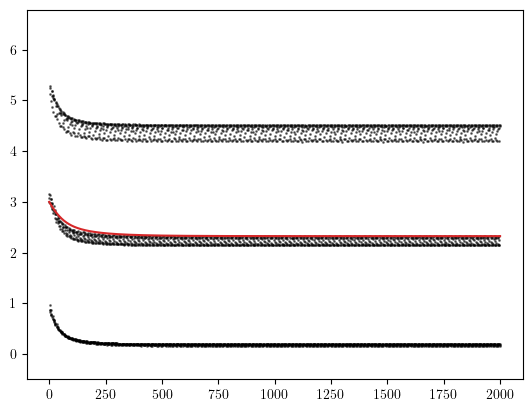

In [72]:
fig,axs = plt.subplots()
y = np.mod(phase12a_p004 - a23_p004.om*phase12b_p004,2*np.pi)
axs.scatter(tp12a_p004,y,s=1,alpha=.5,color='black')

axs.plot(t23_p004,np.mod(solr23_p004.y.T,2*np.pi),color='tab:red')

# axs.plot(t23_p004*a23_p004.om,np.mod(solr12b_p004.y[0]-a23_p004.om*solr12b_p004.y[2],2*np.pi),color='tab:blue')

#axs.plot(t12*a12.om,np.mod(solr12c.y[0]-a12.om*solr12c.y[2],2*np.pi),color='tab:green')
#axs.scatter(sol_full.t[::skipn],np.mod(phase2,1),s=1)

axs.set_ylim(-.5,2*np.pi+.5)

# del=0.005

In [73]:
del23_p005 = 0.005
a23_p005 = nm.nmCoupling(**kw_nm, del1=del23_p005)

pfactor 20
* Loading p symbolic...
* Loading p symbolic...
* Loading H symbolic...
* Loading H symbolic...
* Loading H thal0_35, order=0...
* Loading H thal1_35, order=0...
* Loading H thal0_35, order=1...
* Loading H thal1_35, order=1...
* Loading H thal0_35, order=2...
* Loading H thal1_35, order=2...
* Loading H thal0_35, order=3...
* Loading H thal1_35, order=3...


## Get Branches Full

In [97]:
kw_follow = {'a':a23_p005,'del1':del23_p005,'recompute':False,
         'bifdir':'bif1d_thal2/','_full_rhs':_full,'max_iter':3}

In [98]:
data_list = []

In [99]:
in_dicts = [dict(init=0,eps_init=0.01,eps_final=0.004,deps=-.002),
            dict(init=0,eps_init=0.01,eps_final=0.014,deps=.002)]

In [100]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_follow)
    data_list.append(dat)
fname = kw_follow['bifdir']+'hyper_thal2_23_p005.txt'

fname1 td_branch_init=0_nm=23_del=0.005_ei=0.01_ef=0.004_de=-0.002.txt
fname2 ts_branch_init=0_nm=23_del=0.005_ei=0.01_ef=0.004_de=-0.002.txt
fname1 td_branch_init=0_nm=23_del=0.005_ei=0.01_ef=0.014_de=0.002.txt
fname2 ts_branch_init=0_nm=23_del=0.005_ei=0.01_ef=0.014_de=0.002.txt
init [-4.87474796e-02  2.56217867e-01  2.28625496e-01  4.38772216e-01 -6.30347966e-01  7.36229968e-01  2.54197994e-01  2.36537505e-04  6.25477189e+00]
eps iter 0 0.01                
eps iter 1 0.012                                                        


In [101]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [79]:
data_r3d_p005_list = []

In [80]:
# find init for this branch mid
_,init = phase_lock_r3d([5,0,0],a23_p005,.05,_redu_3dc)
print(init)

[ 4.1801 -0.0146  0.061 ]01, Y=[ 4.18013531 -0.01461394  0.06097542]                                                          


In [81]:
# branch 1
dat = follow_locking_3d(init,a23_p005,(.05,.051,.002),
                        rhs=_redu_3dc,max_iter=5,recompute=False)
data_r3d_p005_list.append(dat)

eps iter 0 0.05                


## Plot

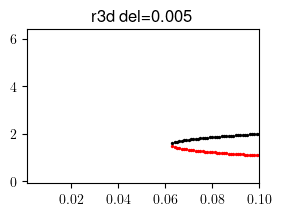

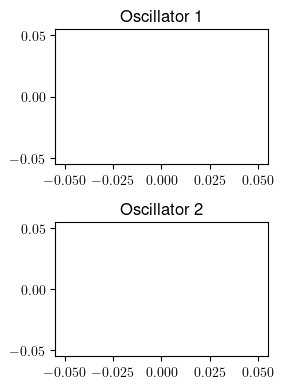

In [82]:
quick_plot_combined(a23_p005,
                    kw_f={'data_list':data_list},
                    kw_r3d={'data_list':data_r3d_p005_list},
                    kw_r={'etup':etup23})